## Comparing companies' free cash flow with cash flow from operations. 

In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels import regression, stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp
import seaborn
from math import sqrt
from scipy.stats import pearsonr

In [2]:
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.factors import AverageDollarVolume
from quantopian.pipeline.filters.morningstar import IsPrimaryShare

Below we see that there is a correlation between the two for transportation companies with market cap over $100 million. However, if we scale both datasets by the company revenue, the fit is much less significant. That is, the correlation between free cash flow and cash flow from operations is largely due to company size, and thus doesn't give us any information.

In [3]:
def make_pipeline():
    
    #Factor returns
    free_cash_flow = Fundamentals.free_cash_flow.latest
    operating_cash_flow = Fundamentals.operating_cash_flow.latest
    total_revenue = Fundamentals.total_revenue.latest
    market_cap = Fundamentals.market_cap.latest > 1e8
    is_liquid = AverageDollarVolume(window_length=5).percentile_between(99.5, 100)
    is_primary = IsPrimaryShare()
   
    universe = (QTradableStocksUS()
                & is_liquid
                & is_primary
                & market_cap)
    

    pipe = Pipeline(
        columns={
            'free_cash_flow': free_cash_flow,
            'operating_cash_flow': operating_cash_flow,
            'total_revenue': total_revenue,
        },
        screen=universe
    )
    
    return pipe
data = run_pipeline(make_pipeline(), start_date='2015-01-01', end_date='2016-01-01')

In [4]:
# Drop missing data
data.dropna(inplace=True)
print len(data)
data.head()

5777


free_cash_flow  \
2015-01-02 00:00:00+00:00 Equity(24 [AAPL])      9.398000e+09   
                          Equity(1406 [CELG])    8.424000e+08   
                          Equity(3149 [GE])      3.198000e+09   
                          Equity(3212 [GILD])    3.908960e+09   
                          Equity(3443 [HAL])    -7.100000e+07   

                                               operating_cash_flow  \
2015-01-02 00:00:00+00:00 Equity(24 [AAPL])           1.325000e+10   
                          Equity(1406 [CELG])         9.009000e+08   
                          Equity(3149 [GE])           6.035000e+09   
                          Equity(3212 [GILD])         4.044022e+09   
                          Equity(3443 [HAL])          8.380000e+08   

                                               total_revenue  
2015-01-02 00:00:00+00:00 Equity(24 [AAPL])     4.212300e+10  
                          Equity(1406 [CELG])   1.982200e+09  
                          Equity(3149 [GE])     3.617400e+10  
                          Equity(3212 [GILD])   6.041832e+09  
                          Equity(3443 [HAL])    8.701000e+09

R-squared value of model: 0.885898833039


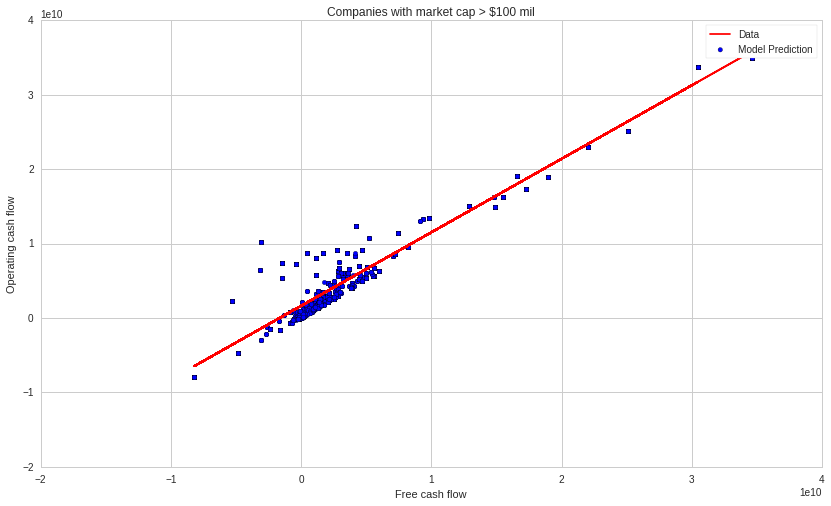

In [5]:
# Run linear regression and print R-squared value to evaluate the goodness of the fit 
unscaled_model = regression.linear_model.OLS(data['operating_cash_flow'],
                                    sm.add_constant(data['free_cash_flow'])).fit()
prediction = unscaled_model.params[0] + unscaled_model.params[1]*data['free_cash_flow']
print 'R-squared value of model:', unscaled_model.rsquared

# Plot the raw data for visualization
plt.scatter(data['free_cash_flow'], data['operating_cash_flow'])
plt.plot(data['free_cash_flow'], prediction, color='r')
plt.legend(['Data', 'Model Prediction'])
plt.xlabel('Free cash flow')
plt.ylabel('Operating cash flow')
plt.title('Companies with market cap > $100 mil');

R-squared value of scaled model: 0.923837543836


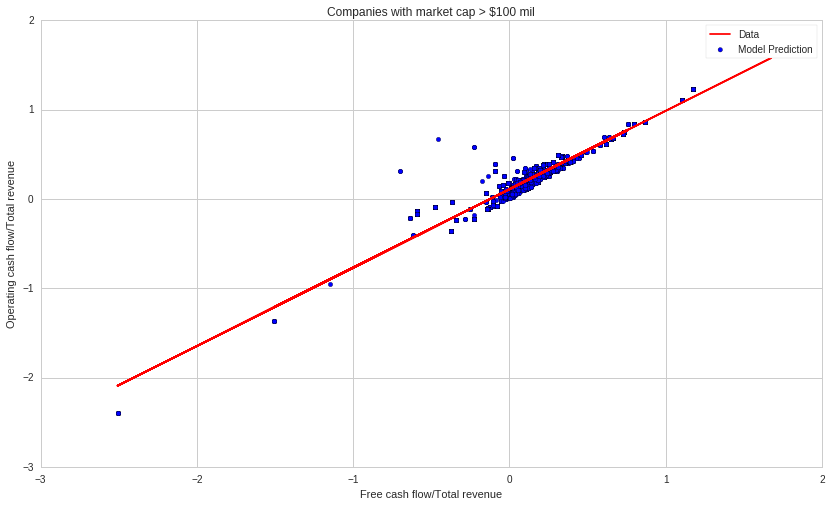

In [6]:
# Run linear regression with inputs scaled by total revenue
scaled_model = regression.linear_model.OLS(
    data['operating_cash_flow'].values/data['total_revenue'].values,
    sm.add_constant(data['free_cash_flow'].values/data['total_revenue'].values), missing='drop').fit()
print 'R-squared value of scaled model:', scaled_model.rsquared

prediction = scaled_model.params[0] + scaled_model.params[1]*(data['free_cash_flow'].values/data['total_revenue'].values)

# Plot the scaled data
plt.scatter(data['free_cash_flow'].values/data['total_revenue'].values,
            data['operating_cash_flow'].values/data['total_revenue'].values)
plt.plot(data['free_cash_flow'].values/data['total_revenue'].values, prediction, color='r')
plt.legend(['Data', 'Model Prediction'])
plt.xlabel('Free cash flow/Total revenue')
plt.ylabel('Operating cash flow/Total revenue')
plt.title('Companies with market cap > $100 mil');

Conversely, we can pool sets of observations which separately demonstrate no correlation, but do appear to fit a correlation model when taken together. To see why this might be a problem, consider a model that compares companies' free cash flow with cash flow from operations. Below we see that there is a correlation between the two for transportation companies with market cap over $100 million. However, if we scale both datasets by the company revenue, the fit is much less significant. That is, the correlation between free cash flow and cash flow from operations is largely due to company size, and thus doesn't give us any information.

In [7]:
def make_pipeline():
    
    #Factor returns
    free_cash_flow = Fundamentals.free_cash_flow.latest
    operating_cash_flow = Fundamentals.operating_cash_flow.latest
    total_revenue = Fundamentals.total_revenue.latest
    market_cap = Fundamentals.market_cap.latest > 1e8 # Filter by market cap & industry
    industry_template_code = Fundamentals.industry_template_code.latest
    
   
    universe = (QTradableStocksUS()
                & market_cap)
    

    pipe = Pipeline(
        columns={
            'free_cash_flow': free_cash_flow,
            'market_cap': market_cap,
            'industry_template_code': industry_template_code,
            'operating_cash_flow': operating_cash_flow,
            'total_revenue': total_revenue,
        },
        screen=universe
    )
    
    return pipe
data = run_pipeline(make_pipeline(), start_date='2019-04-03', end_date='2019-04-04')

In [8]:
# Only include companies in the Transportation industry 
data = data.loc[data.industry_template_code == 'T']
# Drop missing data
data.dropna(inplace=True)
print len(data)
data.head()

100


free_cash_flow  \
2019-04-03 00:00:00+00:00 Equity(41 [ARCB])        74339000.0   
                          Equity(289 [MATX])      -31900000.0   
                          Equity(300 [ALK])      -197000000.0   
                          Equity(1937 [CSX])      730000000.0   
                          Equity(2663 [EXPD])      92218000.0   

                                              industry_template_code  \
2019-04-03 00:00:00+00:00 Equity(41 [ARCB])                        T   
                          Equity(289 [MATX])                       T   
                          Equity(300 [ALK])                        T   
                          Equity(1937 [CSX])                       T   
                          Equity(2663 [EXPD])                      T   

                                              market_cap  operating_cash_flow  \
2019-04-03 00:00:00+00:00 Equity(41 [ARCB])         True         8.176800e+07   
                          Equity(289 [MATX])        True         1.020000e+08   
                          Equity(300 [ALK])         True         2.090000e+08   
                          Equity(1937 [CSX])        True         1.235000e+09   
                          Equity(2663 [EXPD])       True         1.020500e+08   

                                               total_revenue  
2019-04-03 00:00:00+00:00 Equity(41 [ARCB])     7.742790e+08  
                          Equity(289 [MATX])    5.649000e+08  
                          Equity(300 [ALK])     2.064000e+09  
                          Equity(1937 [CSX])    3.143000e+09  
                          Equity(2663 [EXPD])   2.235597e+09

R-squared value of model: 0.287047097928


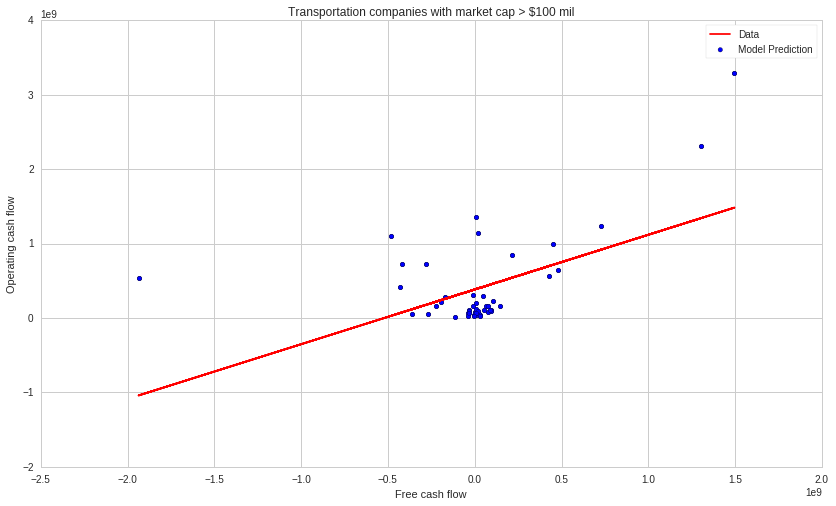

In [9]:
# Run linear regression and print R-squared value to evaluate the goodness of the fit 
unscaled_model = regression.linear_model.OLS(data['operating_cash_flow'],
                                    sm.add_constant(data['free_cash_flow'])).fit()
prediction = unscaled_model.params[0] + unscaled_model.params[1]*data['free_cash_flow']
print 'R-squared value of model:', unscaled_model.rsquared

# Plot the raw data for visualization
plt.scatter(data['free_cash_flow'], data['operating_cash_flow'])
plt.plot(data['free_cash_flow'], prediction, color='r')
plt.legend(['Data', 'Model Prediction'])
plt.xlabel('Free cash flow')
plt.ylabel('Operating cash flow')
plt.title('Transportation companies with market cap > $100 mil');

R-squared value of scaled model: 0.0166959863001


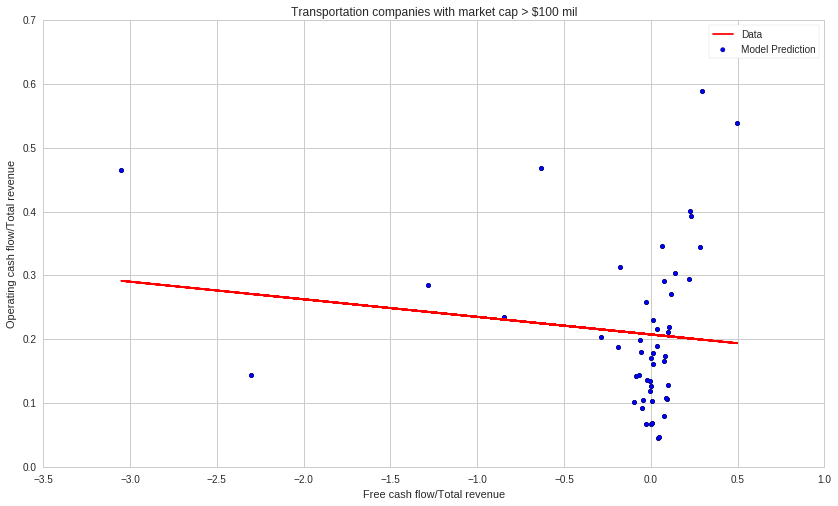

In [10]:
# Run linear regression with inputs scaled by total revenue
scaled_model = regression.linear_model.OLS(
    data['operating_cash_flow'].values/data['total_revenue'].values,
    sm.add_constant(data['free_cash_flow'].values/data['total_revenue'].values), missing='drop').fit()
print 'R-squared value of scaled model:', scaled_model.rsquared

prediction = scaled_model.params[0] + scaled_model.params[1]*(data['free_cash_flow'].values/data['total_revenue'].values)

# Plot the scaled data
plt.scatter(data['free_cash_flow'].values/data['total_revenue'].values,
            data['operating_cash_flow'].values/data['total_revenue'].values)
plt.plot(data['free_cash_flow'].values/data['total_revenue'].values, prediction, color='r')
plt.legend(['Data', 'Model Prediction'])
plt.xlabel('Free cash flow/Total revenue')
plt.ylabel('Operating cash flow/Total revenue')
plt.title('Transportation companies with market cap > $100 mil');